In [1]:
import sys
import numpy as np

import matplotlib as mtp
import matplotlib.pyplot as plt
sys.path.insert(0, "PyATLASstyle")
import PyATLASstyle as pas
pas.applyATLASstyle(mtp)

GeV = 1000

In [2]:
file_path = "../samples/ntuple_v1.root"

# Uproot + Pandas

In [3]:
import uproot3 as upr3
import pandas as pd

In [4]:
arrays_to_open = ["jet_pt_NOSYS", "jet_phi", "jet_eta"]

In [5]:
df = pd.DataFrame(upr3.open(file_path)["analysis"].arrays(arrays_to_open, namedecode="utf-8"))

In [6]:
# number of events
len(df)

40000

In [7]:
df["jet_pt_NOSYS"]

0        [88068.875, 67244.36, 60222.39, 49769.53, 2519...
1        [116802.8, 82981.65, 77938.13, 63455.76, 24229...
2        [60975.89, 61747.17, 58188.297, 46637.984, 402...
3        [65005.863, 61154.26, 60976.09, 57639.797, 257...
4        [170076.19, 140629.44, 35733.164, 37615.555, 1...
                               ...                        
39995    [100117.36, 88533.555, 92773.02, 42057.438, 19...
39996    [87069.25, 83007.32, 40104.13, 35296.3, 20708....
39997    [218181.95, 108714.766, 28838.934, 29332.39, 1...
39998    [137843.3, 81121.0, 76987.805, 62878.76, 40392...
39999    [122521.65, 33772.21, 26725.064, 20402.986, 16...
Name: jet_pt_NOSYS, Length: 40000, dtype: object

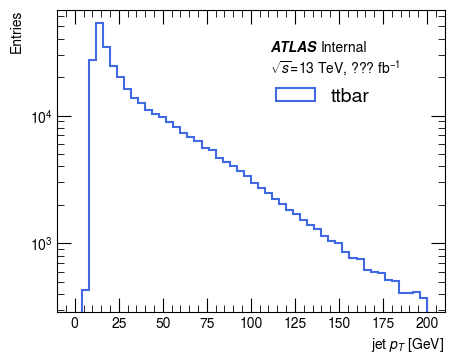

In [8]:
fig, ax = plt.subplots(1, figsize=(5, 4), dpi=100)

ax.hist(
    np.array([x for y in df["jet_pt_NOSYS"] for x in y])/GeV, 50, (0,200), 
    histtype="step", color="royalblue", linewidth=1.5, label="ttbar"
)
ax.set_xlabel("jet $p_T$ [GeV]", loc="right")
ax.set_ylabel("Entries", loc="top")
ax.set_yscale("log")

pas.makeATLAStag(
    ax, fig, first_tag="Internal", second_tag=r"$\sqrt{s}$=13 TeV, ??? fb$^{-1}$", 
    xmin=0.55, ymax=0.85, line_spacing=0.6
)

ax.legend(bbox_to_anchor=(0.52, 0.80), loc="upper left")

plt.show()

# Coffea

In [9]:
import uproot as upr4
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import BaseSchema, NanoEventsFactory

import hist

In [10]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="d_axis", label="", categories=[], growth=True)
        jet_axis = hist.axis.Regular(name="j_axis", label="jet $p_T$ [GeV]", bins=50, start=0, stop=200)
        
        self.output = processor.dict_accumulator({
            'jet_pt': hist.Hist(dataset_axis, jet_axis)
        })
    
    def process(self, events):
        dataset = events.metadata['dataset']
        self.output['jet_pt'].fill(d_axis=dataset, j_axis=ak.flatten(events["jet_pt_NOSYS"])/GeV)
        
        return self.output
    
    def postprocess(self, accumulator):
        pass

In [11]:
file = upr4.open(file_path)
events = NanoEventsFactory.from_root(file, "analysis", metadata={"dataset": "ttbar"}, schemaclass=BaseSchema).events()
p = MyProcessor()
out = p.process(events)

In [12]:
events.fields[:5]

['runNumber', 'eventNumber', 'jet_pt_NOSYS', 'jet_phi', 'jet_eta']

In [13]:
out

{'jet_pt': Hist(
   StrCategory(['ttbar'], growth=True, name='d_axis', label='d_axis'),
   Regular(50, 0, 200, name='j_axis', label='jet $p_T$ [GeV]'),
   storage=Double()) # Sum: 332185.0 (337127.0 with flow)}

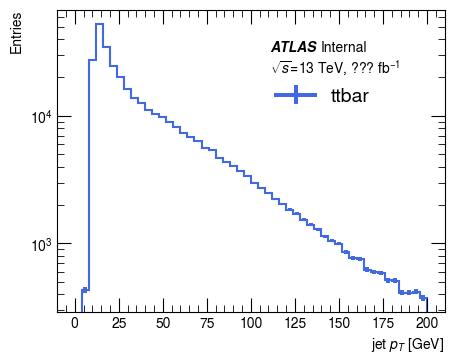

In [14]:
fig, ax = plt.subplots(1, figsize=(5, 4), dpi=100)

out["jet_pt"].plot1d(ax=ax, color="royalblue")

ax.set_xlabel("jet $p_T$ [GeV]", loc="right")
ax.set_ylabel("Entries", loc="top")
ax.set_yscale("log")

pas.makeATLAStag(
    ax, fig, first_tag="Internal", second_tag=r"$\sqrt{s}$=13 TeV, ??? fb$^{-1}$", 
    xmin=0.55, ymax=0.85, line_spacing=0.6
)

ax.legend(bbox_to_anchor=(0.52, 0.80), loc="upper left")

plt.show()